In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from PIL import Image
import folium
import requests
import circlify

import pickle

In [2]:
# plot style
plt.style.use(['science','no-latex'])

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['figure.figsize'] = (6, 3)

# display all rows and columns when printing in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# dtypes = {
#     'DayOfWeek':                       int,
#     'FlightDate':                      'string',
#     'IATA_CODE_Reporting_Airline':     'string',
#     'Tail_Number':                     'string',
#     'Flight_Number_Reporting_Airline': int,
#     'OriginAirportID':                 int,
#     'Origin':                          'string',
#     'OriginState':                     'string',
#     'DestAirportID':                   int,
#     'Dest':                            'string',
#     'DestState':                       'string',
#     'CRSDepTime':                      int,
#     'DepTime':                         int,
#     'DepDelayMinutes':                 int,
#     'CRSArrTime':                      int,
#     'ArrTime':                         int,
#     'ArrDelayMinutes':                 int,
#     'Cancelled':                       int,
#     'CancellationCode':                'string',
#     'Diverted':                        int,
#     'CRSElapsedTime':                  int,
#     'ActualElapsedTime':               int,
#     'AirTime':                         int,
#     'CarrierDelay':                    int,
#     'WeatherDelay':                    int,
#     'NASDelay':                        int,
#     'SecurityDelay':                   int,
#     'LateAircraftDelay':               int,
#     'CRSDepHour':                      int,
#     'OriginTz':                        'string',
#     'DestTz':                          'string',
#     'CRSArrDateTime':                  'string',
#     'CRSArrDate':                      'string',
#     'CRSArrHour':                      int,
#     'o_temperature_2m':                float,
#     'o_relative_humidity_2m':          float,
#     'o_dew_point_2m':                  float,
#     'o_apparent_temperature':          float,
#     'o_precipitation':                 float,
#     'o_rain':                          float,
#     'o_snowfall':                      float,
#     'o_snow_depth':                    float,
#     'o_weather_code':                  float,
#     'o_surface_pressure':              float,
#     'o_cloud_cover':                   float,
#     'o_cloud_cover_low':               float,
#     'o_cloud_cover_mid':               float,
#     'o_cloud_cover_high':              float,
#     'o_wind_speed_10m':                float,
#     'o_wind_speed_100m':               float,
#     'o_wind_gusts_10m':                float,
#     'o_shortwave_radiation':           float,
#     'o_direct_radiation':              float,
#     'o_diffuse_radiation':             float,
#     'o_direct_normal_irradiance':      float,
#     'o_terrestrial_radiation':         float,
#     'o_airport':                       'string',
#     'o_day':                           'string',
#     'o_hour':                          int,
#     'd_temperature_2m':                float,
#     'd_relative_humidity_2m':          float,
#     'd_dew_point_2m':                  float,
#     'd_apparent_temperature':          float,
#     'd_precipitation':                 float,
#     'd_rain':                          float,
#     'd_snowfall':                      float,
#     'd_snow_depth':                    float,
#     'd_weather_code':                  float,
#     'd_surface_pressure':              float,
#     'd_cloud_cover':                   float,
#     'd_cloud_cover_low':               float,
#     'd_cloud_cover_mid':               float,
#     'd_cloud_cover_high':              float,
#     'd_wind_speed_10m':                float,
#     'd_wind_speed_100m':               float,
#     'd_wind_gusts_10m':                float,
#     'd_shortwave_radiation':           float,
#     'd_direct_radiation':              float,
#     'd_diffuse_radiation':             float,
#     'd_direct_normal_irradiance':      float,
#     'd_terrestrial_radiation':         float,
#     'd_airport':                       'string',
#     'd_day':                           'string',
#     'd_hour':                          int
# }

def load_data():
    files = [
        'data/weather-joined/full-w-2017.csv',
        'data/weather-joined/full-w-2018.csv',
        'data/weather-joined/full-w-2019.csv',
    ]

    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    return pd.concat(dfs, ignore_index=True)

In [4]:
flight_df = load_data()
delay_tails = set(flight_df['Tail_Number'].unique())

In [5]:
flight_df = flight_df[['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
       'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin',
       'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'CRSDepHour', 'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate',
       'CRSArrHour']]

In [6]:
bird_df = pd.read_csv('data/bird-strike/bird-strike.csv', low_memory=False)
bird_df = bird_df[(bird_df['INCIDENT_YEAR'] >= 2017) | (bird_df['INCIDENT_YEAR'] <= 2019)]
bird_tails = set(bird_df['REG'].dropna().unique())

In [7]:
common_tails = delay_tails.intersection(bird_tails)
len(common_tails)

6317

In [8]:
bird_df['INCIDENT_DATE'] = pd.to_datetime(bird_df['INCIDENT_DATE'])
flight_df['FlightDate'] = pd.to_datetime(flight_df['FlightDate'])

/tmp/ipykernel_338886/2540889832.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bird_df['INCIDENT_DATE'] = pd.to_datetime(bird_df['INCIDENT_DATE'])


In [9]:
strike_df = pd.merge(flight_df, bird_df, left_on=['Tail_Number', 'FlightDate'], right_on=['REG', 'INCIDENT_DATE'], how='inner')

In [10]:
len(strike_df['REG'].unique())

4789

In [11]:
strike_df = strike_df.groupby(['INDEX_NR']).first().reset_index()
strike_df.shape

(33471, 134)

In [12]:
# Don't
# def match_airport(row):
#     return row['AIRPORT_ID'] == 'K' + row['Origin'] or row['AIRPORT_ID'] == 'K' + row['Dest']

# # Apply the custom function to filter rows
# strike_df = strike_df[strike_df.apply(match_airport, axis=1)]
# strike_df = strike_df.groupby(['INDEX_NR']).first().reset_index()

In [13]:
strike_df.groupby('DAMAGE_LEVEL').agg({'DepDelayMinutes': 'mean', 'ArrDelayMinutes': 'mean'})#['DepDelayMinutes', 'ArrDelayMinutes'].mean()

,DepDelayMinutes,ArrDelayMinutes
DAMAGE_LEVEL,,
M,20.606383,25.465753
M?,21.770833,26.126679
N,12.449458,15.389455
S,58.888889,133.875000


In [14]:
strike_df.describe()

,INDEX_NR,DayOfWeek,FlightDate,Flight_Number_Reporting_Airline,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,CRSArrHour,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,HEIGHT,SPEED,AOS,COST_REPAIRS,COST_OTHER,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ,INGESTED_OTHER,INDICATED_DAMAGE,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,BIRD_BAND_NUMBER,REMAINS_COLLECTED,REMAINS_SENT,NR_INJURIES,NR_FATALITIES,TRANSFER,DISTANCE
count,3.347100e+04,33471.000000,33471,33471.000000,33471.000000,33471.000000,33471.000000,14328.000000,33471.000000,33471.000000,14255.000000,14244.000000,33471.000000,33471.000000,33471.000000,14244.000000,14244.000000,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000,33471.000000,33471.000000,33471,33471.000000,33471.000000,29355.000000,29355.000000,15388.000000,15218.000000,18555.000000,18557.000000,18554.000000,18381.000000,73.000000,33.000000,10696.000000,5167.000000,746.000000,1.000000e+02,292.000000,1.000000e+02,292.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.0,33471.000000,33471.000000,33471.000000,33471.000000,33471.0,33471.0,33471.000000,33471.000000,33471.0,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,33471.000000,5.900000e+01,33471.000000,33471.000000,0.0,0.0,33471.0,24143.000000
mean,9.004111e+05,3.877237,2018-08-21 05:34:55.724656896,2150.172328,12500.223268,12789.080995,1197.751755,1289.297878,6.634460,1353.463685,1426.293581,15.841898,0.578859,0.006334,148.477010,138.117102,113.609239,19.332304,4.922397,17.901347,0.102722,19.063009,11.419916,12.822652,2018-08-21 05:34:55.724656896,7.230827,2018.078785,36.780251,-92.425581,15.432545,3.302011,3.859229,1.997467,2.108440,2.072684,2.397260,1.909091,842.886500,153.050319,16.288767,1.354518e+05,10595.544521,1.596077e+05,12272.027397,0.022706,0.021989,0.062024,0.002689,0.075140,0.001046,0.084611,0.001912,0.026859,0.002450,0.0,0.026052,0.002779,0.000030,0.000030,0.0,0.0,0.000090,0.000030,0.0,0.001135,0.000090,0.086911,0.005916,0.054435,0.001255,0.026710,0.000747,0.005139,0.001135,0.002032,0.001076,0.173852,0.002898,1.076238e+08,0.747602,0.253563,NaN,NaN,0.0,0.667398
min,7.867620e+05,1.000000,2017-01-02 00:00:00,1.000000,10135.000000,10136.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,27.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017-01-02 00:00:00,1.000000,2017.000000,-34.822222,-171.732778,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.100000,5.000000e+01,1.000000,5.800000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,0.0,0.000000
25%,8.065605e+05,2.000000,2017-10-29 00:00:00,640.000000,11111.000000,11298.000000,720.000000,814.000000,0.000000,914.000000,953.000000,0.000000,0.000000,0.000000,92.000000,85.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,8.000000,2017-10-29 00:00:00,5.000000,2017.000000,32.895950,-98.469780,10.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.00

In [15]:
state_data = strike_df.groupby('STATE').size().sort_values(ascending=False)

In [16]:
state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

In [22]:
m = folium.Map(location=[39, -96], zoom_start=4, width=1440, height=800)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    key_on="feature.id",
    fill_color="PuBu",
    # fill_opacity=0.7,
    # line_opacity=0.2,
    legend_name="Bird strike count",
).add_to(m)

folium.LayerControl().add_to(m)

# m

m.save('bird-strike-count-map.eps')

In [17]:
species = strike_df['SPECIES'].dropna().str.lower()
species = species[~species.str.contains('unknown')]
word_string=" ".join(species)

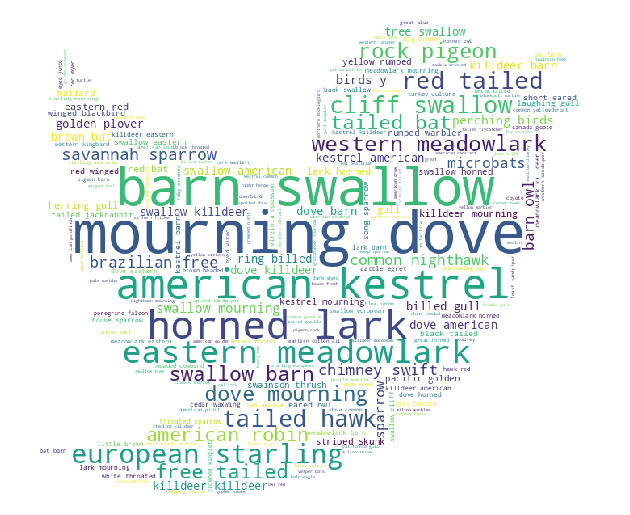

In [21]:
# word_string=" ".join(species)
mask = np.array(Image.open(r'birb4.jpg'))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(mask = mask, stopwords=stopwords, 
               background_color = "white",
               max_words = 1000,
               colormap='viridis', #viridis, RdYlGn
               max_font_size = 500,
               random_state = 42, )
wordcloud.generate(word_string)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='None')
plt.axis("off")
plt.savefig("bad-birb.png", dpi=1200, bbox_inches="tight")
plt.show()

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

operator_data = strike_df.groupby('OPERATOR').size().sort_values(ascending=True)
op_df = pd.DataFrame({'operator':operator_data.index, 'count':operator_data.values})

op_df = op_df[~op_df['operator'].str.contains("UNKNOWN")]
op_df2 = op_df[op_df['count']>70]
op_df2.tail()

,operator,count
181,SKYWEST AIRLINES,1325
182,UNITED AIRLINES,1551
183,DELTA AIR LINES,2477
184,AMERICAN AIRLINES,2863
185,SOUTHWEST AIRLINES,3712


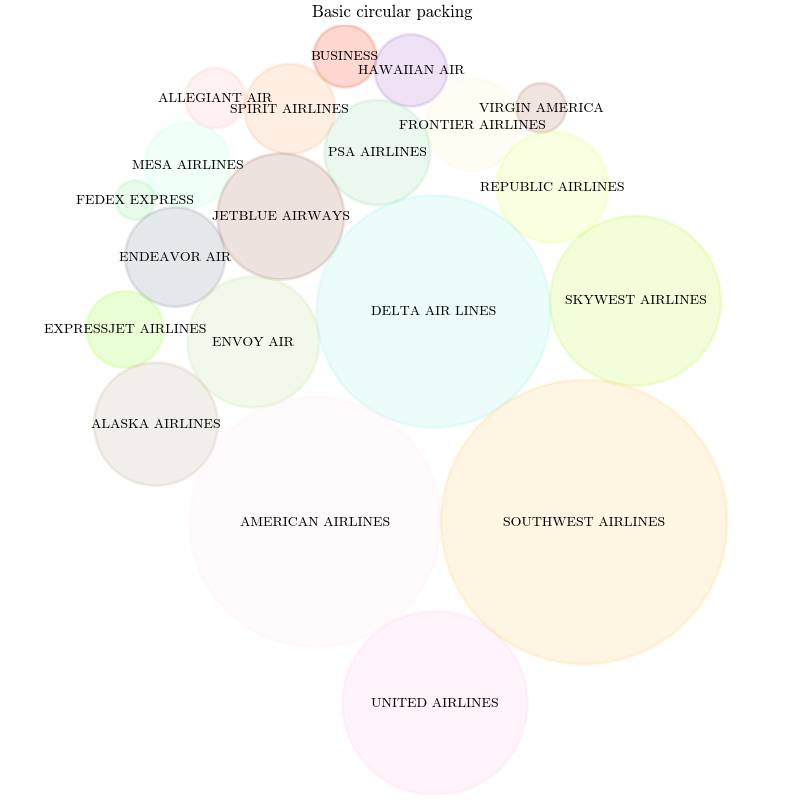

In [34]:
circles = circlify.circlify(
    op_df2['count'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Basic circular packing')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# num_colors = 20
# colors = np.random.rand(num_colors, 3)
# # colors[:, 0] += 0.5  # make all colors slightly brighter
# # colors[:, 1] += 0.2  # make all colors slightly more saturated
# # print(colors)
# list of labels
labels = op_df2['operator']

#(np.random.random(), np.random.random(), np.random.random())
# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=(min(1,np.random.random()+0.5), min(1, np.random.random()+0.2), np.random.random())))
    plt.annotate(
          label, 
          (x,y),
          va='center',
          ha='center'
     )

In [44]:
strike_df.groupby(['REG']).size().sort_values(ascending=False).head(13)
# strike_df[strike_df['DAMAGE_LEVEL'] == 'S'].groupby('Tail_Number').size()

REG
N467WN    13
N489HA    13
N8647A    12
N422WN    12
N494HA    12
N492HA    11
N407WN    11
N479HA    11
N958WN    11
N704US    11
N309FR    11
N405WN    11
N7840A    11
dtype: int64